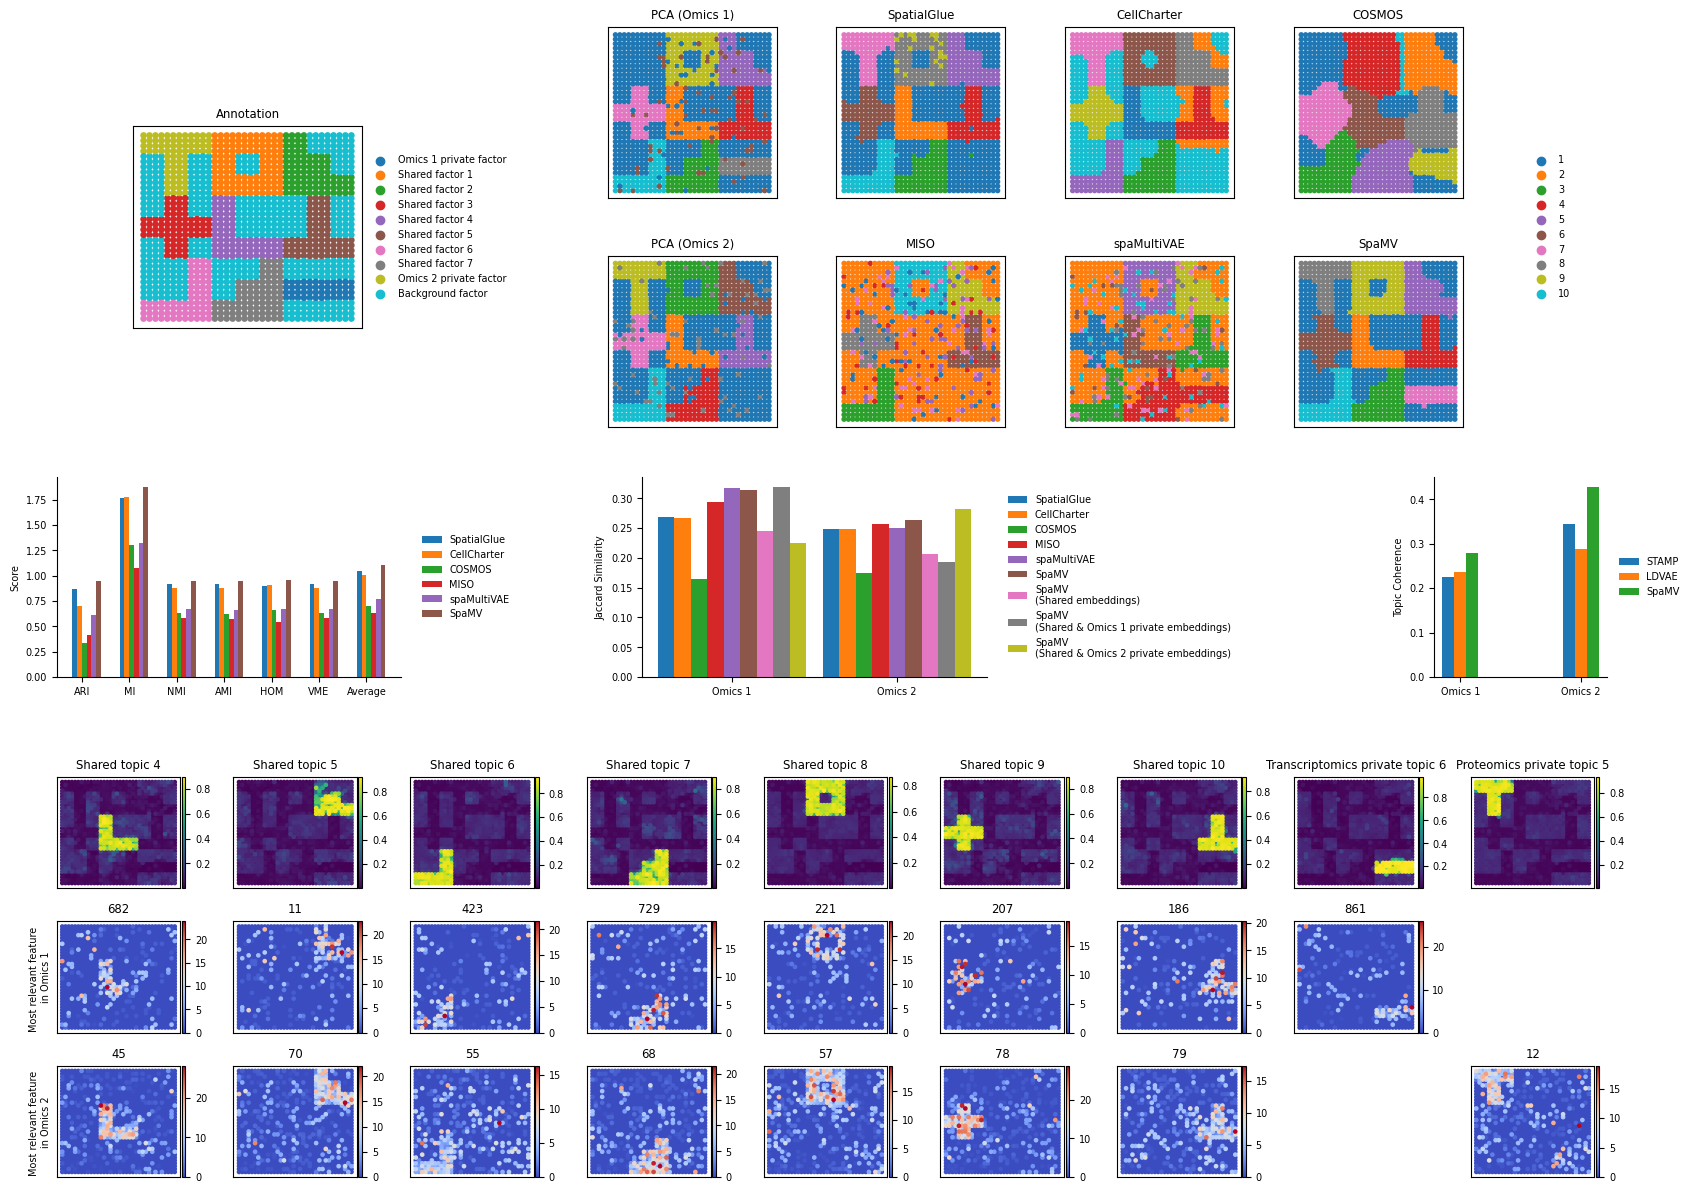

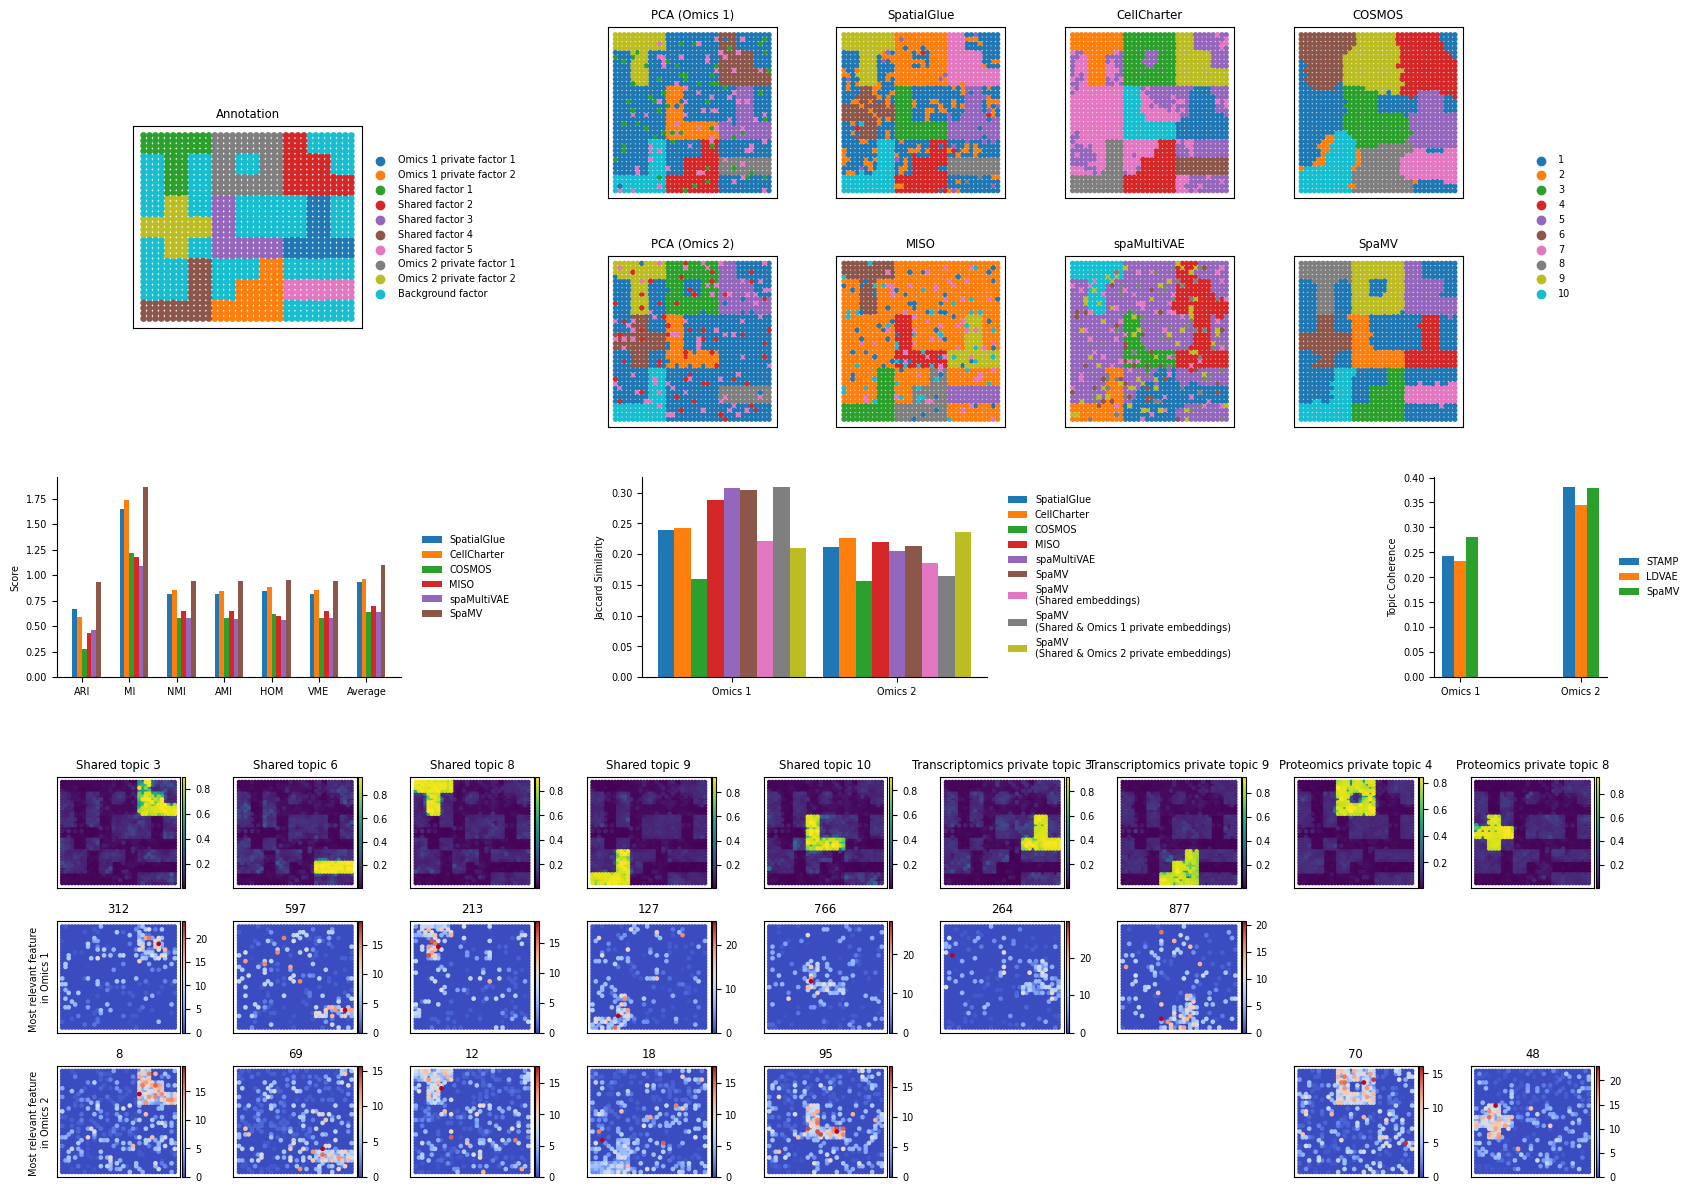

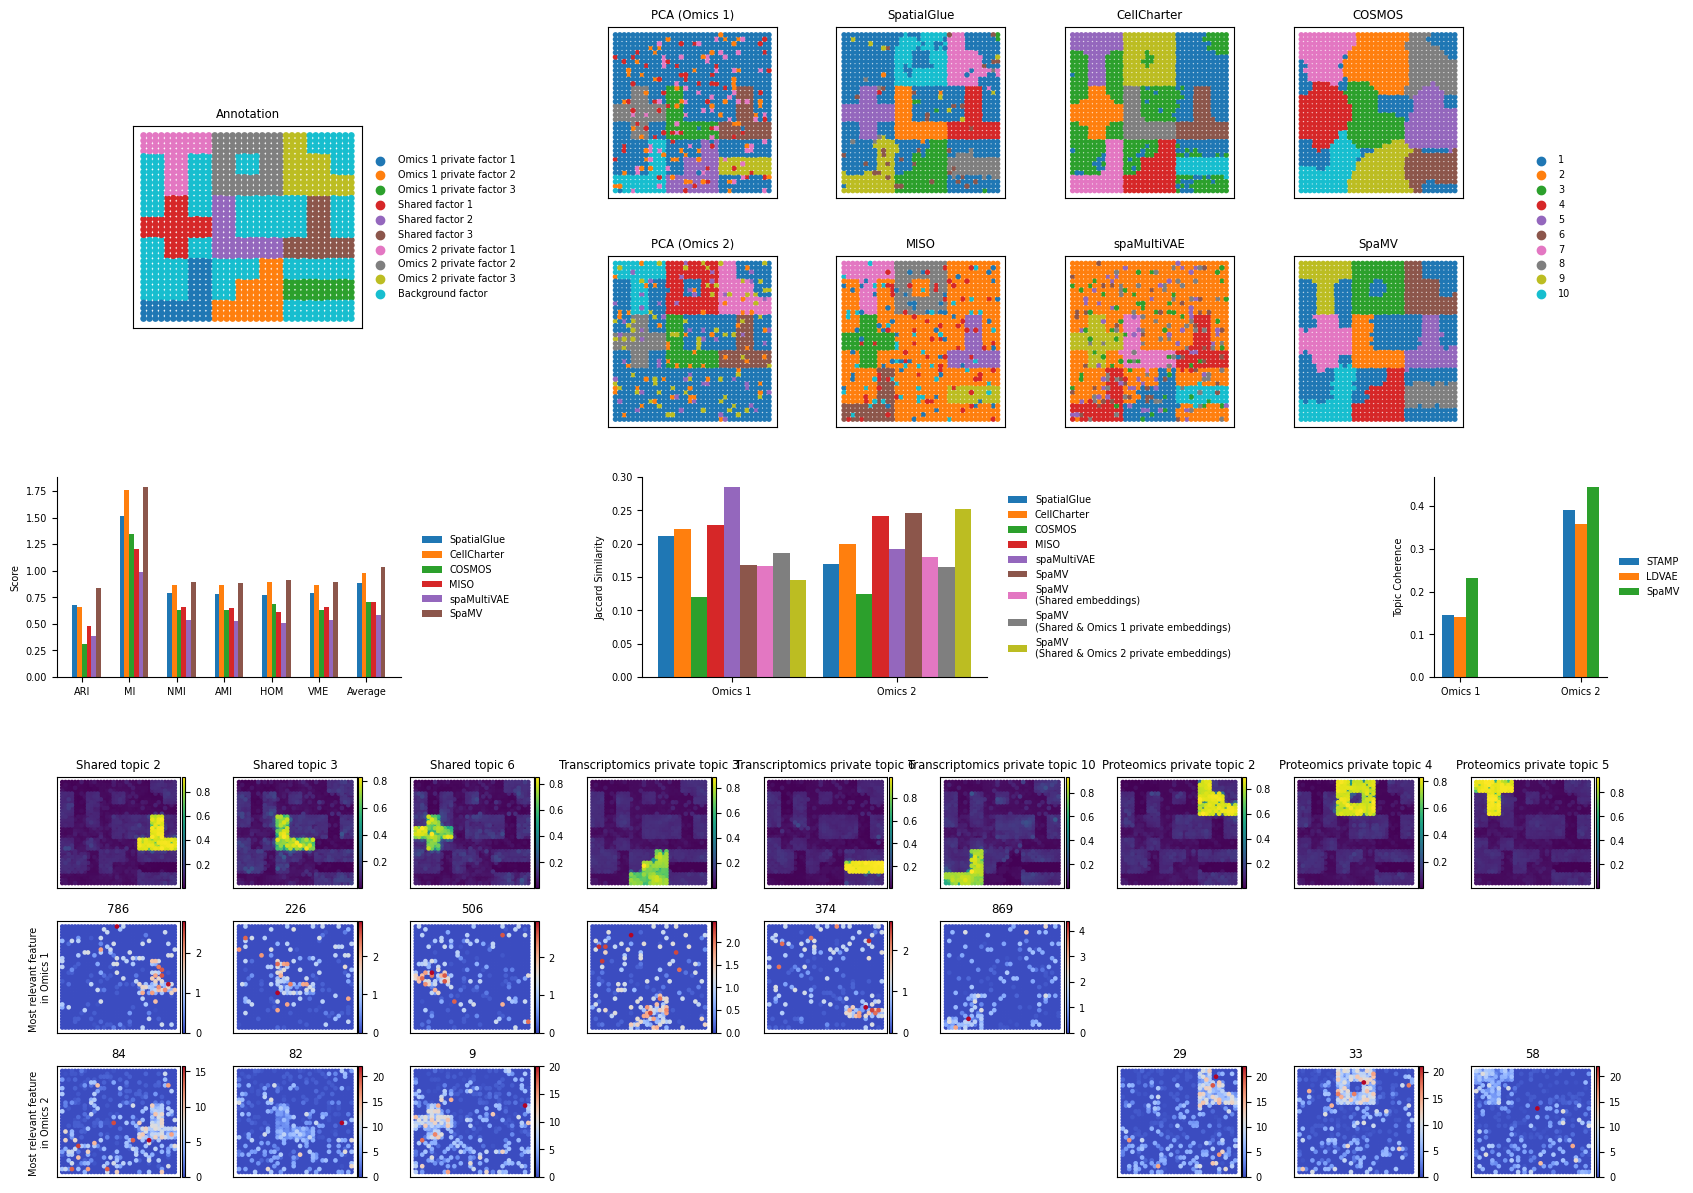

In [6]:
import os, sys
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import scanpy as sc
from scanpy.plotting import embedding
import squidpy as sq
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec

# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(os.path.dirname(current_dir)))
from Methods.SpaMV.metrics import compute_supervised_scores, compute_jaccard, compute_topic_coherence

plt.rcParams.update({'font.size': 7})


def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")


# Define the softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return e_x / e_x.sum()


n_topics = 10
gt_size = 90
cluster_size = 60
dr_size = 45
width = 20
height = 13
k = 50
methods = ['PCA_Omics1', 'PCA_Omics2', 'SpatialGlue', 'CellCharter', 'COSMOS', 'MISO', 'spaMultiVAE', 'SpaMV']
methods_dr = ['STAMP', 'LDVAE']
clustering_scale = {'top': 1 - .5 / height, 'bottom': 1 - 4.5 / height}
score_scale = {'top': 1 - 5 / height, 'bottom': 1 - 7 / height}
dr_scale = {'top': 1 - 8 / height, 'bottom': 1 - 12 / height}
# load simulated dataset
for dataset in ['1_Simulation', '2_Simulation', '3_Simulation']:
    data_rna = sc.read_h5ad('../../Dataset/' + dataset + '/adata_RNA.h5ad')
    sc.pp.normalize_total(data_rna)
    sc.pp.pca(data_rna, n_comps=30)
    data_pro = sc.read_h5ad('../../Dataset/' + dataset + '/adata_ADT.h5ad')
    sc.pp.normalize_total(data_pro)
    sc.pp.pca(data_pro, n_comps=30)

    ###############################################################################################################################
    # plot clustering results
    if '1_Simulation' in dataset:
        data_rna.obs['cluster'].replace(
            {0: 'Omics 2 private factor', 1: 'Shared factor 1', 2: 'Shared factor 2', 3: 'Shared factor 3',
             4: 'Shared factor 4', 5: 'Shared factor 5', 6: 'Shared factor 6', 7: 'Shared factor 7',
             8: 'Omics 1 private factor', 9: 'Background factor'}, inplace=True)
        data_rna.obs['cluster'] = pd.Categorical(data_rna.obs['cluster'],
                                                 categories=['Omics 1 private factor', 'Shared factor 1',
                                                             'Shared factor 2', 'Shared factor 3', 'Shared factor 4',
                                                             'Shared factor 5', 'Shared factor 6', 'Shared factor 7',
                                                             'Omics 2 private factor', 'Background factor'],
                                                 ordered=True)
    elif '2_Simulation' in dataset:
        data_rna.obs['cluster'].replace(
            {0: 'Shared factor 1', 1: 'Omics 2 private factor 1', 2: 'Shared factor 2', 3: 'Omics 2 private factor 2',
             4: 'Shared factor 3', 5: 'Omics 1 private factor 1', 6: 'Shared factor 4', 7: 'Omics 1 private factor 2',
             8: 'Shared factor 5', 9: 'Background factor'}, inplace=True)
        data_rna.obs['cluster'] = pd.Categorical(data_rna.obs['cluster'],
                                                 categories=['Omics 1 private factor 1', 'Omics 1 private factor 2',
                                                             'Shared factor 1', 'Shared factor 2', 'Shared factor 3',
                                                             'Shared factor 4', 'Shared factor 5',
                                                             'Omics 2 private factor 1', 'Omics 2 private factor 2',
                                                             'Background factor'], ordered=True)
    else:
        data_rna.obs['cluster'].replace(
            {0: 'Omics 2 private factor 1', 1: 'Omics 2 private factor 2', 2: 'Omics 2 private factor 3',
             3: 'Shared factor 1', 4: 'Shared factor 2', 5: 'Shared factor 3', 6: 'Omics 1 private factor 1',
             7: 'Omics 1 private factor 2', 8: 'Omics 1 private factor 3', 9: 'Background factor'}, inplace=True)
        data_rna.obs['cluster'] = pd.Categorical(data_rna.obs['cluster'],
                                                 categories=['Omics 1 private factor 1', 'Omics 1 private factor 2',
                                                             'Omics 1 private factor 3', 'Shared factor 1',
                                                             'Shared factor 2', 'Shared factor 3',
                                                             'Omics 2 private factor 1', 'Omics 2 private factor 2',
                                                             'Omics 2 private factor 3', 'Background factor'],
                                                 ordered=True)

    fig = plt.figure(figsize=(width, height))
    # TODO：调height_ratios让annotation居中
    spec_clustering = GridSpec(4, 9, width_ratios=[.2, 1, 1, 1.5, 2, 2, 2, 2, 1], height_ratios=[.7, 1.2, 1.2, .7],
                               wspace=0.5, hspace=1)
    spec_clustering.update(**clustering_scale)

    data_results = {}
    clustering_supervised_results = {}
    clustering_unsupervised_results = {}
    f_dict = {}
    f_dict['Annotation'] = plt.subplot(spec_clustering[1:3, 1:3])
    embedding(data_rna, color='cluster', ax=f_dict['Annotation'], basis='spatial', title='Annotation', show=False,
              size=gt_size)
    for method in methods:
        data_results[method] = sc.read_h5ad('../../Results/' + dataset + '/' + method + '.h5ad')
        if method == 'PCA_Omics1':
            f_dict[method] = plt.subplot(spec_clustering[:2, 4])
        elif method == 'SpatialGlue':
            f_dict[method] = plt.subplot(spec_clustering[:2, 5])
        elif method == 'CellCharter':
            f_dict[method] = plt.subplot(spec_clustering[:2, 6])
        elif method == 'COSMOS':
            f_dict[method] = plt.subplot(spec_clustering[:2, 7])
        elif method == 'PCA_Omics2':
            f_dict[method] = plt.subplot(spec_clustering[2:, 4])
        elif method == 'MISO':
            f_dict[method] = plt.subplot(spec_clustering[2:, 5])
        elif method == 'spaMultiVAE':
            f_dict[method] = plt.subplot(spec_clustering[2:, 6])
        elif method == 'SpaMV':
            f_dict[method] = plt.subplot(spec_clustering[2:, 7])
            # f_dict[method + ' Shared embeddings'] = plt.subplot(spec_clustering[2:, 5])
            # f_dict[method + ' Omics 1 private embedding'] = plt.subplot(spec_clustering[2:, 6])
            # f_dict[method + ' Omics 2 private embedding'] = plt.subplot(spec_clustering[2:, 7])

        #  TODO: 对其颜色 custom_palette
        #     custom_palette = {
        # 1: '#1f77b4',  # 蓝色
        # 2: '#ff7f0e',  # 橙色
        # 3: '#2ca02c',  # 绿色
        # 4: '#d62728',  # 红色
        # 5: '#9467bd',  # 紫色
        # 6: '#8c564b',  # 棕色
        # 7: '#e377c2',  # 粉色
        # 8: '#7f7f7f',  # 灰色
        # 9: '#bcbd22',  # 黄绿色
        # 10: '#17becf',  # 青色
        # }
        if method == 'SpaMV':
            embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      size=cluster_size)
        elif 'PCA_Omics1' in method:
            embedding(data_results[method], color='PCA (Omics 1)', ax=f_dict[method], basis='spatial',
                      legend_loc='none', show=False, size=cluster_size)
        elif 'PCA_Omics2' in method:
            embedding(data_results[method], color='PCA (Omics 2)', ax=f_dict[method], basis='spatial',
                      legend_loc='none', show=False, size=cluster_size)
        else:
            embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      legend_loc='none', size=cluster_size)

        if 'PCA' not in method:
            clustering_supervised_results[method] = compute_supervised_scores(data_results[method], method.split('_')[0])
            data_rna.obsm[method] = data_results[method].obsm[method]
            data_pro.obsm[method] = data_results[method].obsm[method]
            clustering_unsupervised_results[method] = {'Omics 1': compute_jaccard(data_rna, method, k=k),
                                                       'Omics 2': compute_jaccard(data_pro, method, k=k)}
        if method == 'SpaMV':
            # embedding(data_results[method], color=method + '_Shared', ax=f_dict[method + ' Shared embeddings'], basis='spatial', show=False, size=cluster_size)
            # embedding(data_results[method], color=method + '_Omics 1', ax=f_dict[method + ' Omics 1 private embedding'], basis='spatial', show=False, legend_loc='none', size=cluster_size)
            # embedding(data_results[method], color=method + '_Omics 2', ax=f_dict[method + ' Omics 2 private embedding'], basis='spatial', show=False, legend_loc='none', size=cluster_size)
            data_rna.obsm[method + ' Shared embeddings'] = data_results[method].obsm[method + '_Shared']
            data_pro.obsm[method + ' Shared embeddings'] = data_results[method].obsm[method + '_Shared']
            data_rna.obsm[method + ' Shared & Omics 1 private embeddings'] = np.concat(
                (data_results[method].obsm[method + '_Shared'], data_results[method].obsm[method + '_Omics 1']), 1)
            data_pro.obsm[method + ' Shared & Omics 1 private embeddings'] = np.concat(
                (data_results[method].obsm[method + '_Shared'], data_results[method].obsm[method + '_Omics 1']), 1)
            data_rna.obsm[method + ' Shared & Omics 2 private embeddings'] = np.concat(
                (data_results[method].obsm[method + '_Shared'], data_results[method].obsm[method + '_Omics 2']), 1)
            data_pro.obsm[method + ' Shared & Omics 2 private embeddings'] = np.concat(
                (data_results[method].obsm[method + '_Shared'], data_results[method].obsm[method + '_Omics 2']), 1)
            clustering_unsupervised_results[method + ' Shared embeddings'] = {
                'Omics 1': compute_jaccard(data_rna, method + ' Shared embeddings', k=k),
                'Omics 2': compute_jaccard(data_pro, method + ' Shared embeddings', k=k)}
            clustering_unsupervised_results[method + ' Shared & Omics 1 private embeddings'] = {
                'Omics 1': compute_jaccard(data_rna, method + ' Shared & Omics 1 private embeddings', k=k),
                'Omics 2': compute_jaccard(data_pro, method + ' Shared & Omics 1 private embeddings', k=k)}
            clustering_unsupervised_results[method + ' Shared & Omics 2 private embeddings'] = {
                'Omics 1': compute_jaccard(data_rna, method + ' Shared & Omics 2 private embeddings', k=k),
                'Omics 2': compute_jaccard(data_pro, method + ' Shared & Omics 2 private embeddings', k=k)}
    legend = plt.subplot(spec_clustering[:, 8])

    handles, labels = f_dict['SpaMV'].get_legend_handles_labels()
    legend.legend(handles, labels, loc='center left', frameon=False)
    legend.axis('off')
    f_dict['SpaMV'].get_legend().remove()
    for f in f_dict.values():
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    ###############################################################################################################################
    # plot metrics scores
    # TODO: 调整width_ratios让不同的metrics结果比例协调
    spec_score = GridSpec(1, 5, width_ratios=[1, .7, 1, 1.3, .5], wspace=0)
    spec_score.update(**score_scale)
    clustering_supervised = plt.subplot(spec_score[0, 0])

    # Extract metrics and algorithms
    metrics = list(next(iter(clustering_supervised_results.values())).keys())

    # Number of metrics and algorithms
    num_metrics = len(metrics)
    num_algorithms = len(methods)

    # Prepare data for plotting
    index = np.arange(num_metrics)
    bar_width = .1

    for i, method in enumerate(methods):
        if 'PCA' not in method:
            metric_scores = [clustering_supervised_results[method][metric] for metric in metrics]
            clustering_supervised.bar(index + i * bar_width, metric_scores, bar_width, label=method)

    # Add labels and title
    clustering_supervised.set_ylabel('Score')
    clustering_supervised.set_xticks(index + bar_width * (num_algorithms - 1) / 2)
    clustering_supervised.set_xticklabels(metrics)
    clustering_supervised.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, frameon=False)

    # Remove the top and right spines
    clustering_supervised.spines['top'].set_visible(False)
    clustering_supervised.spines['right'].set_visible(False)

    # Remove the x-axis label
    clustering_supervised.set_xlabel('')  # Set the x-axis label to an empty string

    clustering_unsupervised = plt.subplot(spec_score[0, 2])

    # Prepare data for plotting
    index = np.arange(2)
    bar_width = .1

    for i, method in enumerate(methods + ['SpaMV Shared embeddings', 'SpaMV Shared & Omics 1 private embeddings',
                                          'SpaMV Shared & Omics 2 private embeddings']):
        if 'PCA' not in method:
            metric_scores = [clustering_unsupervised_results[method][metric] for metric in ['Omics 1', 'Omics 2']]
            if ' ' in method:
                label = method[:5] + '\n(' + method[6:] + ')'
                clustering_unsupervised.bar(index + i * bar_width, metric_scores, bar_width, label=label)
            else:
                clustering_unsupervised.bar(index + i * bar_width, metric_scores, bar_width, label=method)

    # Add labels and title
    clustering_unsupervised.set_ylabel('Jaccard Similarity')
    clustering_unsupervised.set_xticks(index + bar_width * (13 - 1) / 2)
    clustering_unsupervised.set_xticklabels(['Omics 1', 'Omics 2'])
    clustering_unsupervised.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, frameon=False)

    # Remove the top and right spines
    clustering_unsupervised.spines['top'].set_visible(False)
    clustering_unsupervised.spines['right'].set_visible(False)

    # Remove the x-axis label
    clustering_unsupervised.set_xlabel('')  # Set the x-axis label to an empty string

    # plot dimensionality reduction unsupervised results
    bar_width = .1
    topk_RNA = 10
    topk_ADT = 5
    spot_topic = pd.read_csv('../../Results/' + dataset + '/spot_topic.csv')
    feature_topic = [pd.read_csv('../../Results/' + dataset + '/feature_topic_1.csv', index_col=0),
                     pd.read_csv('../../Results/' + dataset + '/feature_topic_2.csv', index_col=0)]
    feature_topic[0].index = feature_topic[0].index.astype(str)
    feature_topic[1].index = feature_topic[1].index.astype(str)
    if dataset == '1_Simulation':
        spot_topic = spot_topic.drop(columns='Transcriptomics private topic 4')
        feature_topic[0] = feature_topic[0].drop(columns='Transcriptomics private topic 4')

    # Apply softmax to each row
    spot_topic_softmax = spot_topic.apply(lambda row: softmax(row), axis=1)
    data_rna.obs = spot_topic_softmax
    dr_unsupervised = plt.subplot(spec_score[0, 4])
    dr_unsupervised_results = {"SpaMV": {'Omics 1': compute_topic_coherence(data_rna, feature_topic[0], topk=topk_RNA),
                                         'Omics 2': compute_topic_coherence(data_pro, feature_topic[1], topk=topk_ADT)}}
    for method in methods_dr:
        d0 = sc.read_h5ad('../../Results/' + dataset + '/' + method + '_Transcriptomics.h5ad')
        d1 = sc.read_h5ad('../../Results/' + dataset + '/' + method + '_Proteomics.h5ad')
        dr_unsupervised_results[method] = {
            'Omics 1': compute_topic_coherence(data_rna, d0.uns['feature_topic'], topk=topk_RNA),
            'Omics 2': compute_topic_coherence(data_pro, d1.uns['feature_topic'], topk=topk_ADT)}

    for i, method in enumerate(methods_dr + ['SpaMV']):
        metric_scores = [dr_unsupervised_results[method][metric] for metric in ['Omics 1', 'Omics 2']]
        dr_unsupervised.bar(index + i * bar_width, metric_scores, bar_width, label=method)

    # Add labels and title
    dr_unsupervised.set_ylabel('Topic Coherence')
    dr_unsupervised.set_xticks(index + bar_width * (3 - 1) / 2)
    dr_unsupervised.set_xticklabels(['Omics 1', 'Omics 2'])
    dr_unsupervised.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, frameon=False)

    # Remove the top and right spines
    dr_unsupervised.spines['top'].set_visible(False)
    dr_unsupervised.spines['right'].set_visible(False)

    # Remove the x-axis label
    dr_unsupervised.set_xlabel('')  # Set the x-axis label to an empty string
    ###############################################################################################################################
    # plot dimension reduction results
    spec_dr = GridSpec(3, 9, width_ratios=[1] * 9, height_ratios=[1] * 3, hspace=.3, wspace=.3)
    spec_dr.update(**dr_scale)
    f_dict = {}
    i = 0
    for topic in spot_topic.columns:
        if i == 0:
            f_preserved = [topic + '_1', topic + '_2']
        f_dict[topic] = plt.subplot(spec_dr[0, i])
        embedding(data_rna, color=spot_topic.columns[i], basis='spatial', size=dr_size, ax=f_dict[topic], show=False,
                  legend_loc='none')
        if topic.split(' ')[0] in ['Shared', 'Transcriptomics']:
            f_dict[topic + '_1'] = plt.subplot(spec_dr[1, i])
            embedding(data_rna, color=str(feature_topic[0].nlargest(1, topic).index[0]), basis='spatial', size=dr_size,
                      cmap='coolwarm', ax=f_dict[topic + '_1'], show=False)
        if topic.split(' ')[0] in ['Shared', 'Proteomics']:
            f_dict[topic + '_2'] = plt.subplot(spec_dr[2, i])
            embedding(data_pro, color=str(feature_topic[1].nlargest(1, topic).index[0]), basis='spatial', size=dr_size,
                      cmap='coolwarm', ax=f_dict[topic + '_2'], show=False)
        i += 1
    for key, f in f_dict.items():
        f.axes.get_xaxis().set_visible(False)
        if key in f_preserved and '_1' in key:
            f.set_ylabel('Most relevant feature \nin Omics 1')
        elif key in f_preserved and '_2' in key:
            f.set_ylabel("Most relevant feature \nin Omics 2")
        else:
            f.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.savefig('../../Figures/visualisation_2_' + dataset + '.pdf')
    plt.show()